In [83]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
!pip install graphistry python-dotenv

# Load data

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

plt.style.use("ggplot")
figsize(20, 10)

In [25]:
import arviz as az
import bambi as bmb

In [3]:
df = pd.read_csv("survey_results_public.csv")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.FormalEducation = df.FormalEducation.map(
    {
        "Bachelor’s degree (BA, BS, B.Eng., etc.)": "Bachelor’s degree",
        "Master’s degree (MA, MS, M.Eng., MBA, etc.)": "Master’s degree",
        "Some college/university study without earning a degree": "Some college/university, no degree",
        "Associate degree": "Associate degree",
        "Other doctoral degree (Ph.D, Ed.D., etc.)": "Doctoral degree",
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
        "Professional degree (JD, MD, etc.)": "Professional degree",
        "Primary/elementary school": "Primary/elementary school",
        "I never completed any formal education": "no formal education",
    }
)

In [5]:
companySize_to_interval = {
    "Fewer than 10 employees": pd.Interval(0, 10),
    "10 to 19 employees": pd.Interval(10, 19),
    "20 to 99 employees": pd.Interval(20, 99),
    "100 to 499 employees": pd.Interval(100, 499),
    "500 to 999 employees": pd.Interval(500, 999),
    "1,000 to 4,999 employees": pd.Interval(1000, 4999),
    "5,000 to 9,999 employees": pd.Interval(5000, 9999),
    "10,000 or more employees": pd.Interval(10000, float("inf")),
}

df.CompanySize = df.CompanySize.map(companySize_to_interval)

# Salary

In [90]:
sample = df.query(
    "Country == 'United States' & Employment == 'Employed full-time' & Student == 'No'"
)

<IPython.core.display.Javascript object>

In [91]:
normal_salary = sample[sample["ConvertedSalary"] < 300_000].copy()

<IPython.core.display.Javascript object>

In [92]:
bins = [0, 25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 300_000]

normal_salary["Salary Range"] = pd.cut(
    normal_salary.dropna(subset=["ConvertedSalary"])["ConvertedSalary"], bins=bins
)

salary_groupby = normal_salary.groupby("Salary Range").agg({"Respondent": "count"})
salary_groupby

,Respondent
Salary Range,
"(0, 25000]",62
"(25000, 50000]",514
"(50000, 75000]",2082
"(75000, 100000]",2625
"(100000, 125000]",2250
"(125000, 150000]",1521
"(150000, 300000]",1110


<IPython.core.display.Javascript object>

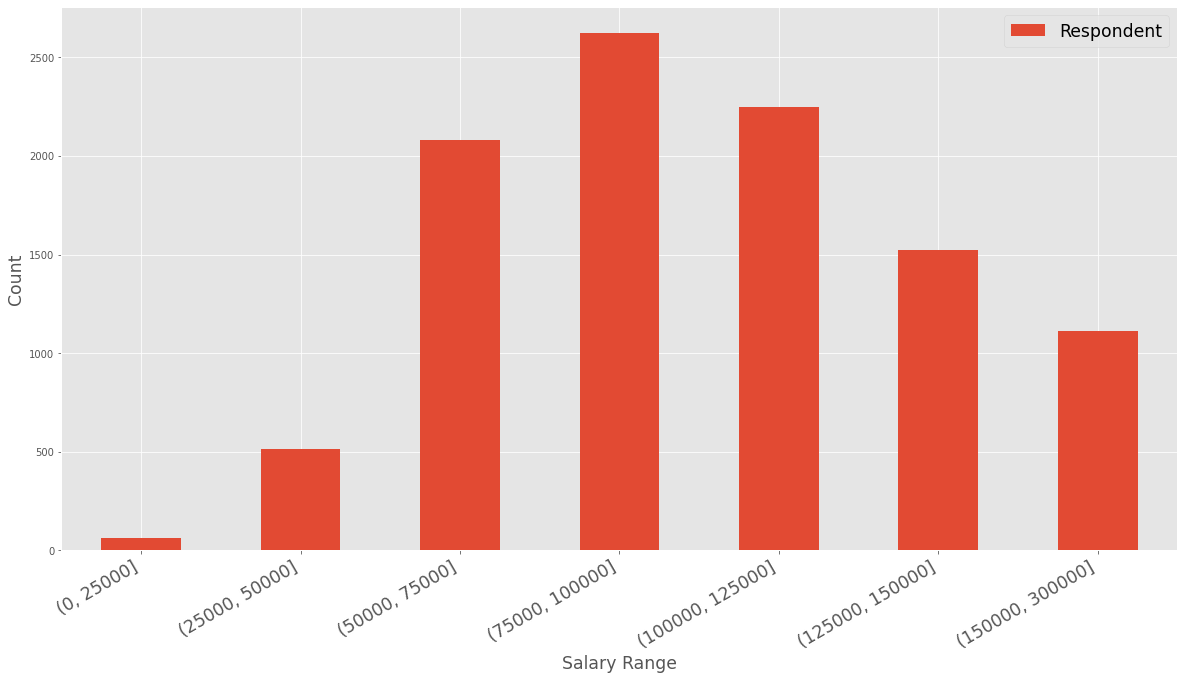

<IPython.core.display.Javascript object>

In [93]:
salary_groupby.plot(kind="bar")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.legend(fontsize="xx-large")
plt.xlabel("Salary Range", fontsize="xx-large")
plt.ylabel("Count", fontsize="xx-large")
plt.show()

## Salary by Years Coding

In [95]:
normal_salary.YearsCoding.head(10)

6           9-11 years
8     30 or more years
23         18-20 years
32           6-8 years
33           3-5 years
35         12-14 years
43          9-11 years
46         15-17 years
47           3-5 years
49         15-17 years
Name: YearsCoding, dtype: object

<IPython.core.display.Javascript object>

In [50]:
def str_to_interval(text: str):
    if isinstance(text, str):
        years = text.split()[0].split("-")
        if len(years) == 2:
            return pd.Interval(int(years[0]), int(years[1]))
        else:
            return pd.Interval(int(years[0]), float("inf"))

    return text

In [98]:
normal_salary.YearsCoding = normal_salary.YearsCoding.apply(str_to_interval)

<IPython.core.display.Javascript object>

In [99]:
years_sorted = normal_salary.dropna(
    subset=["ConvertedSalary", "YearsCoding"]
).sort_values(by="YearsCoding")

<IPython.core.display.Javascript object>

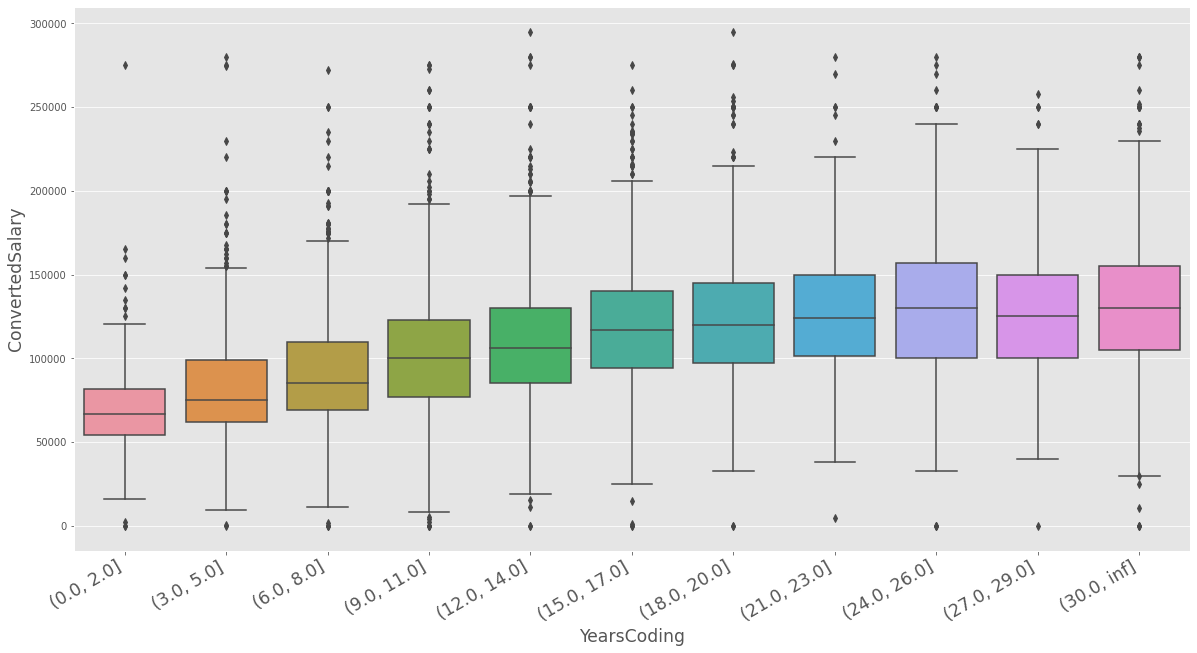

<IPython.core.display.Javascript object>

In [100]:
sns.boxplot(data=years_sorted, x="YearsCoding", y="ConvertedSalary")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("YearsCoding", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

In [54]:
years_sorted.YearsCoding = years_sorted.YearsCoding.astype(str)

In [56]:
years_sorted.YearsCoding.unique()

array(['(0.0, 2.0]', '(3.0, 5.0]', '(6.0, 8.0]', '(9.0, 11.0]',
       '(12.0, 14.0]', '(15.0, 17.0]', '(18.0, 20.0]', '(21.0, 23.0]',
       '(24.0, 26.0]', '(27.0, 29.0]', '(30.0, inf]'], dtype=object)

In [58]:
years_sample1 = years_sorted[(years_sorted.YearsCoding == '(0.0, 2.0]') | (years_sorted.YearsCoding == '(3.0, 5.0]')]

In [65]:
all_model = bmb.Model("ConvertedSalary ~ YearsCoding", years_sorted)
all_results = all_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ConvertedSalary_sigma, Intercept, YearsCoding]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [66]:
az.summary(all_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,70041.873,1831.871,66609.996,73282.800,72.675,51.413,636.0,1243.0,1.0
"YearsCoding[(12.0, 14.0]]",40556.577,2136.393,36488.737,44459.727,78.514,55.540,742.0,1416.0,1.0
"YearsCoding[(15.0, 17.0]]",48780.346,2203.070,44555.504,52692.605,75.957,53.759,844.0,1859.0,1.0
"YearsCoding[(18.0, 20.0]]",52886.243,2163.762,48925.485,56906.640,77.307,54.685,784.0,1710.0,1.0
"YearsCoding[(21.0, 23.0]]",56942.977,2445.111,52274.635,61322.402,77.096,54.531,1009.0,2072.0,1.0
"YearsCoding[(24.0, 26.0]]",63243.693,2669.015,58484.896,68340.055,82.319,58.347,1053.0,2030.0,1.0
"YearsCoding[(27.0, 29.0]]",59964.932,3283.203,53485.296,65665.679,83.706,59.202,1540.0,2465.0,1.0
"YearsCoding[(3.0, 5.0]]",11478.524,2028.639,7351.942,14850.294,74.056,52.386,754.0,1494.0,1.0
"YearsCoding[(30.0, inf]]",63413.395,2350.857,58991.149,67839.822,79.936,56.612,865.0,1581.0,1.0
"YearsCoding[(6.0, 8.0]]",20574.112,2007.769,16556.417,23971.861,74.893,52.979,720.0,1383.0,1.0


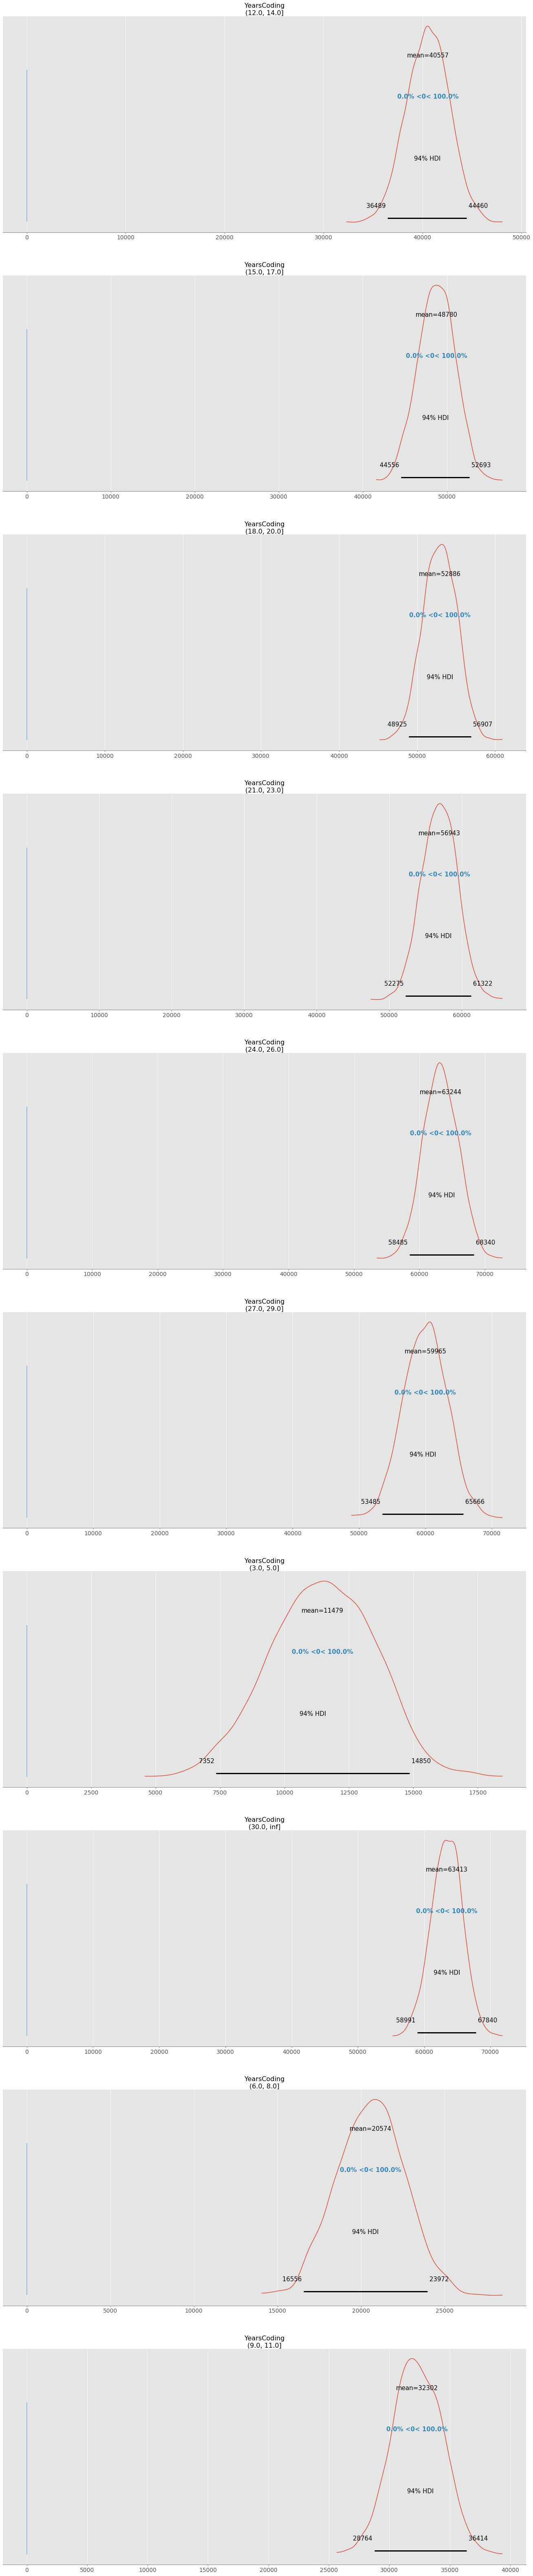

In [73]:
az.plot_posterior(all_results.posterior['YearsCoding'], ref_val=0, grid=(10, 1));

## Salary by Formal Education

In [323]:
ordered_degrees = [
    "no formal education",
    "Primary/elementary school",
    "Secondary school",
    "Some college/university, no degree",
    "Associate degree",
    "Bachelor’s degree",
    "Master’s degree",
    "Professional degree",
    "Doctoral degree",
]

normal_salary.FormalEducation = normal_salary.FormalEducation.astype("category")
normal_salary.FormalEducation.cat.set_categories(
    ordered_degrees, ordered=True, inplace=True
)

sort_by_education = normal_salary.dropna(
    subset=["ConvertedSalary", "FormalEducation"]
).sort_values(by="FormalEducation")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>

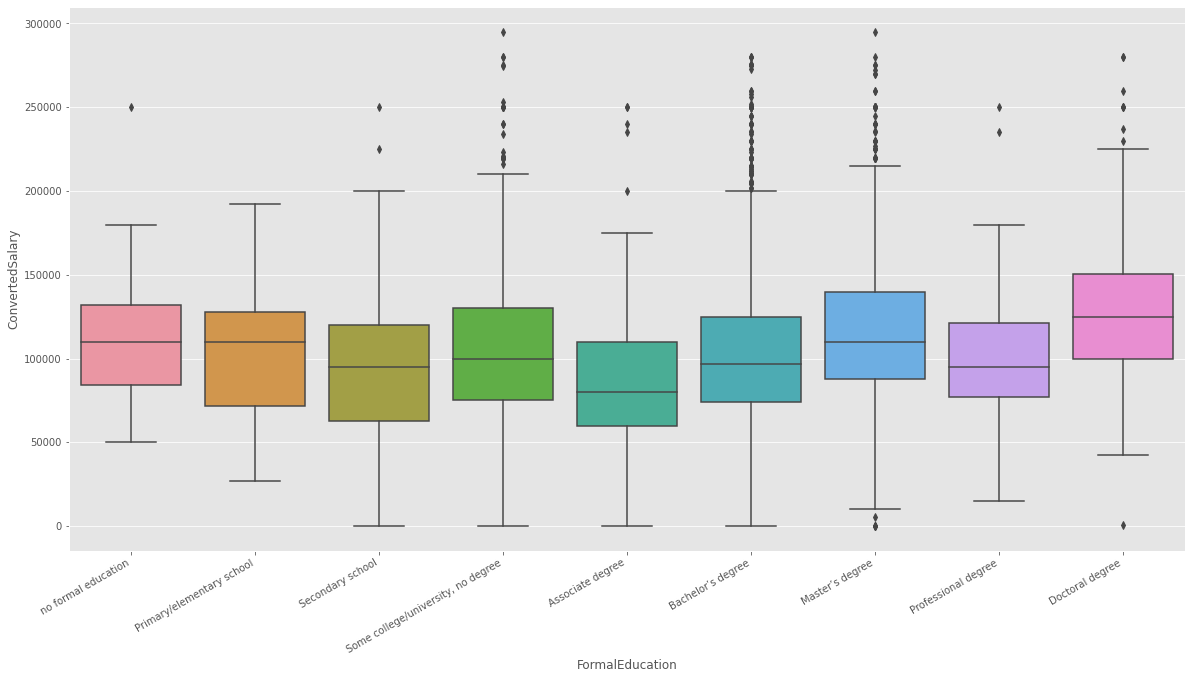

<IPython.core.display.Javascript object>

In [333]:
sns.boxplot(
    data=sort_by_education,
    x="FormalEducation",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Company Size

In [335]:
size_sorted = normal_salary.dropna(
    subset=["ConvertedSalary", "CompanySize"]
).sort_values(by="CompanySize")

<IPython.core.display.Javascript object>

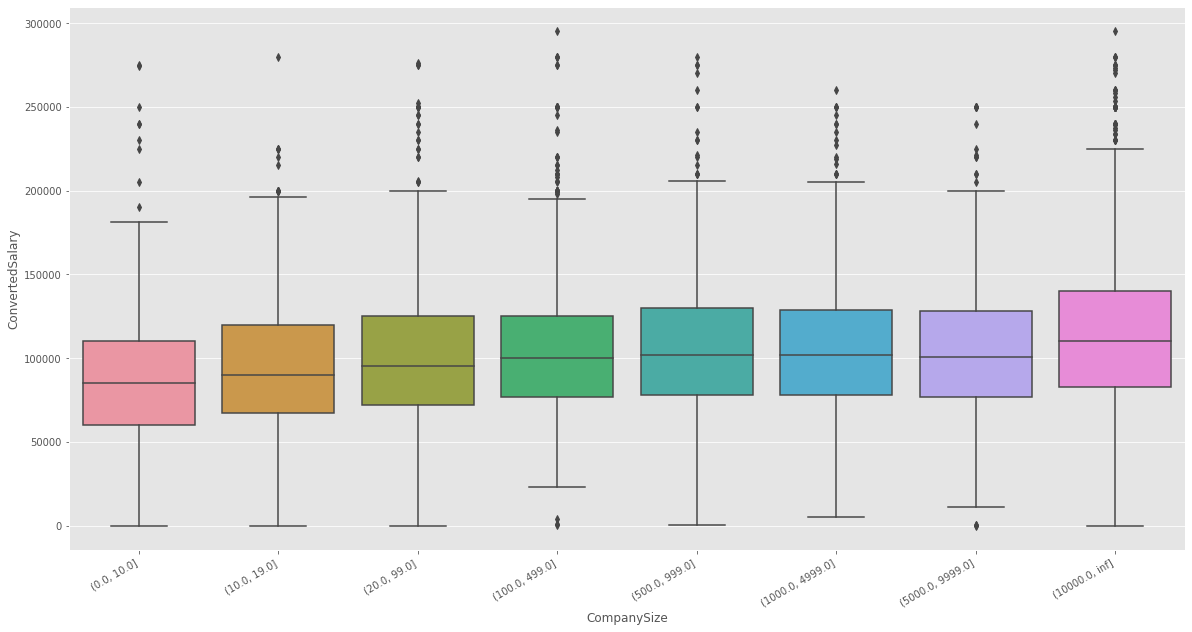

<IPython.core.display.Javascript object>

In [336]:
sns.boxplot(
    data=size_sorted,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Developer Type

In [337]:
def str_to_list(text: str):
    if isinstance(text, str):
        return text.split(";")
    return text

<IPython.core.display.Javascript object>

In [338]:
normal_salary["DevType"] = normal_salary.DevType.apply(str_to_list)

<IPython.core.display.Javascript object>

In [339]:
devtype = normal_salary.explode(column="DevType").dropna(
    subset=["ConvertedSalary", "DevType"]
)

<IPython.core.display.Javascript object>

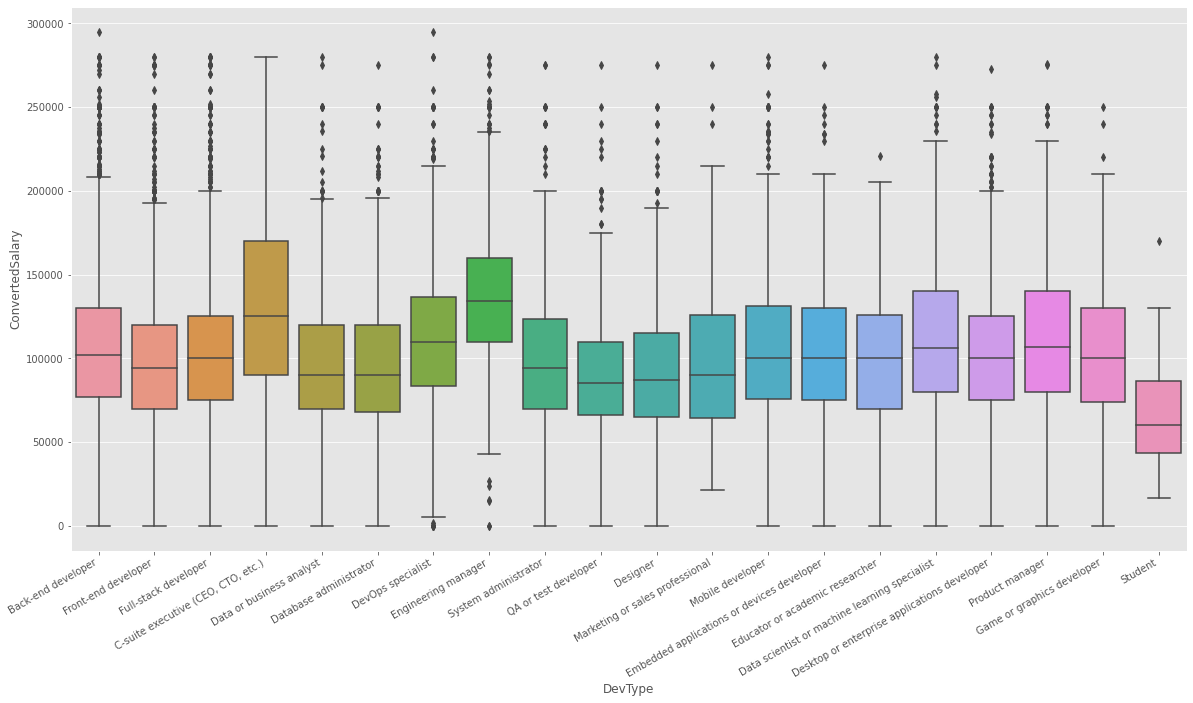

<IPython.core.display.Javascript object>

In [340]:
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=devtype,
    x="DevType",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

### Salary of CEO by Company Size

In [341]:
ceo = devtype.query("DevType == 'C-suite executive (CEO, CTO, etc.)'").sort_values(
    by="CompanySize"
)

<IPython.core.display.Javascript object>

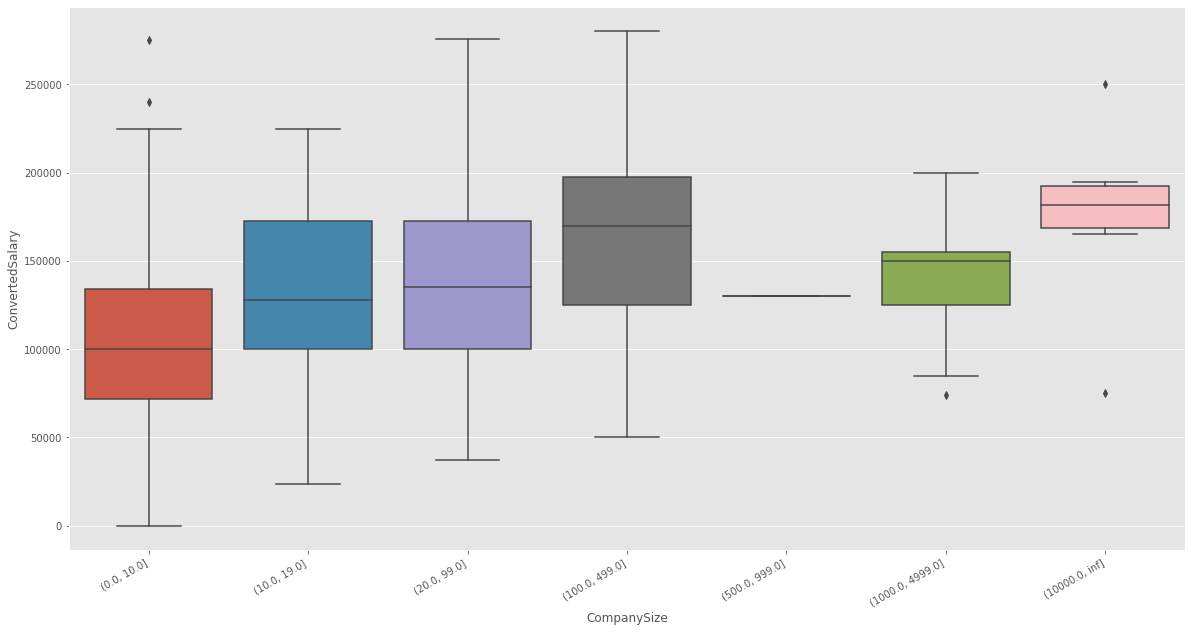

<IPython.core.display.Javascript object>

In [342]:
sns.boxplot(
    data=ceo,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

### Salary of Data Professionals by Company Size

In [343]:
ml = devtype.query(
    "DevType == 'Data scientist or machine learning specialist'"
).sort_values(by="CompanySize")

<IPython.core.display.Javascript object>

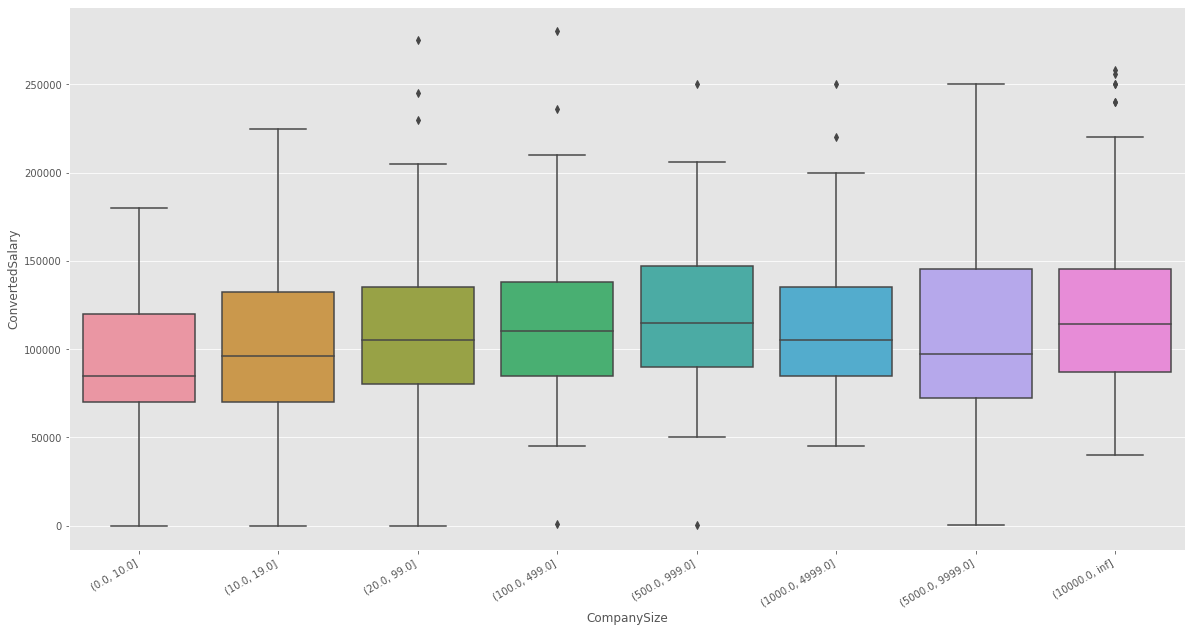

<IPython.core.display.Javascript object>

In [344]:
sns.boxplot(
    data=ml,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Company Size and Years Coding

In [345]:
size_sorted["YearsCoding > 10"] = size_sorted["YearsCoding"].apply(
    lambda row: row.right > 10 if isinstance(row, pd.Interval) else row
)

<IPython.core.display.Javascript object>

In [346]:
years_sorted["CompanySize > 500"] = years_sorted["CompanySize"].apply(
    lambda row: row.right > 500 if isinstance(row, pd.Interval) else row
)

<IPython.core.display.Javascript object>

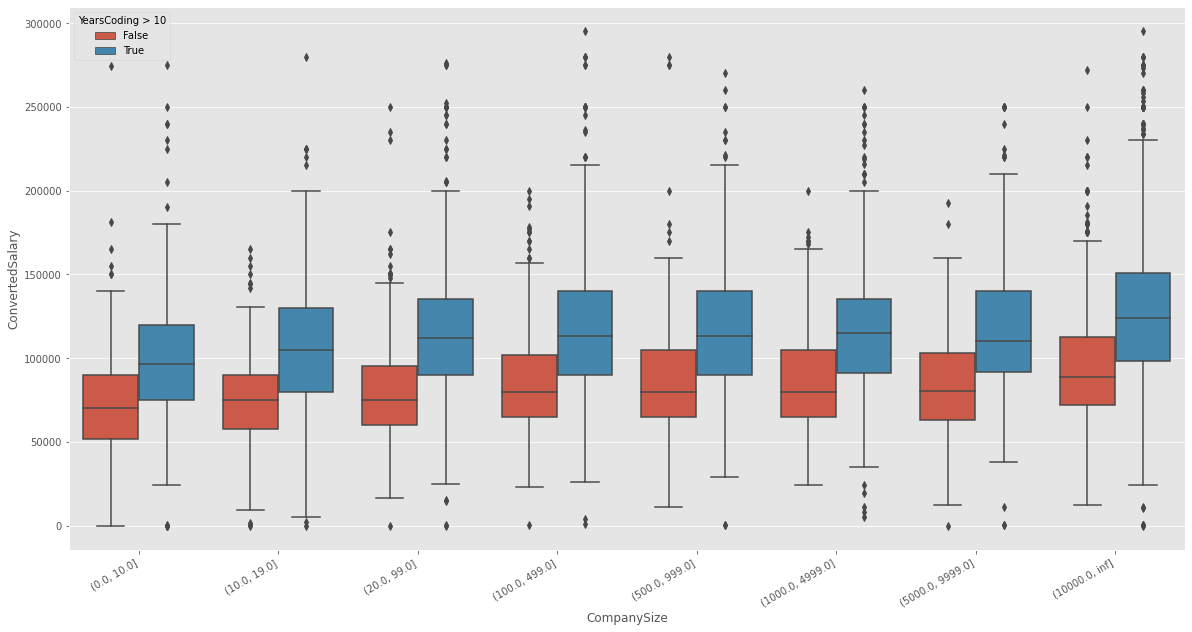

<IPython.core.display.Javascript object>

In [347]:
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=size_sorted, x="CompanySize", y="ConvertedSalary", hue="YearsCoding > 10"
)
plt.xticks(rotation=30, ha="right")
plt.show()

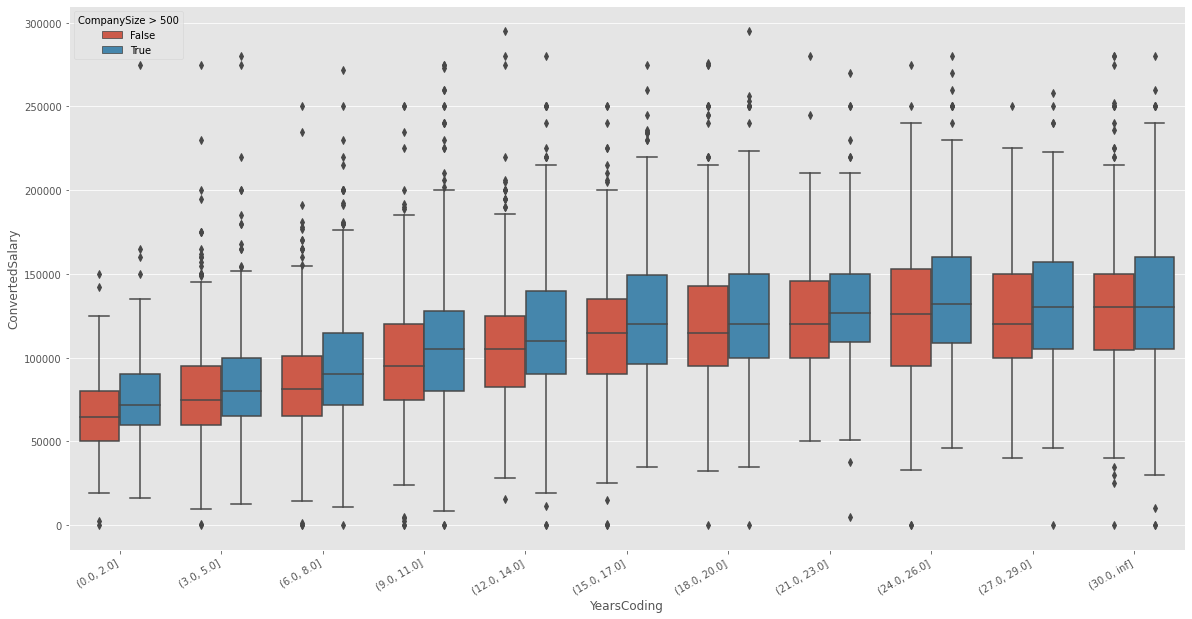

<IPython.core.display.Javascript object>

In [348]:
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=years_sorted, x="YearsCoding", y="ConvertedSalary", hue="CompanySize > 500"
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Job Satisfaction

In [349]:
ordered_satisfaction = [
    "Extremely dissatisfied",
    "Moderately dissatisfied",
    "Slightly dissatisfied",
    "Neither satisfied nor dissatisfied",
    "Slightly satisfied",
    "Moderately satisfied",
    "Extremely satisfied",
]

normal_salary.JobSatisfaction = normal_salary.JobSatisfaction.astype("category")
normal_salary.JobSatisfaction.cat.set_categories(
    ordered_satisfaction, ordered=True, inplace=True
)

sort_by_satisfaction = normal_salary.dropna(
    subset=["ConvertedSalary", "JobSatisfaction"]
).sort_values(by="JobSatisfaction")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>

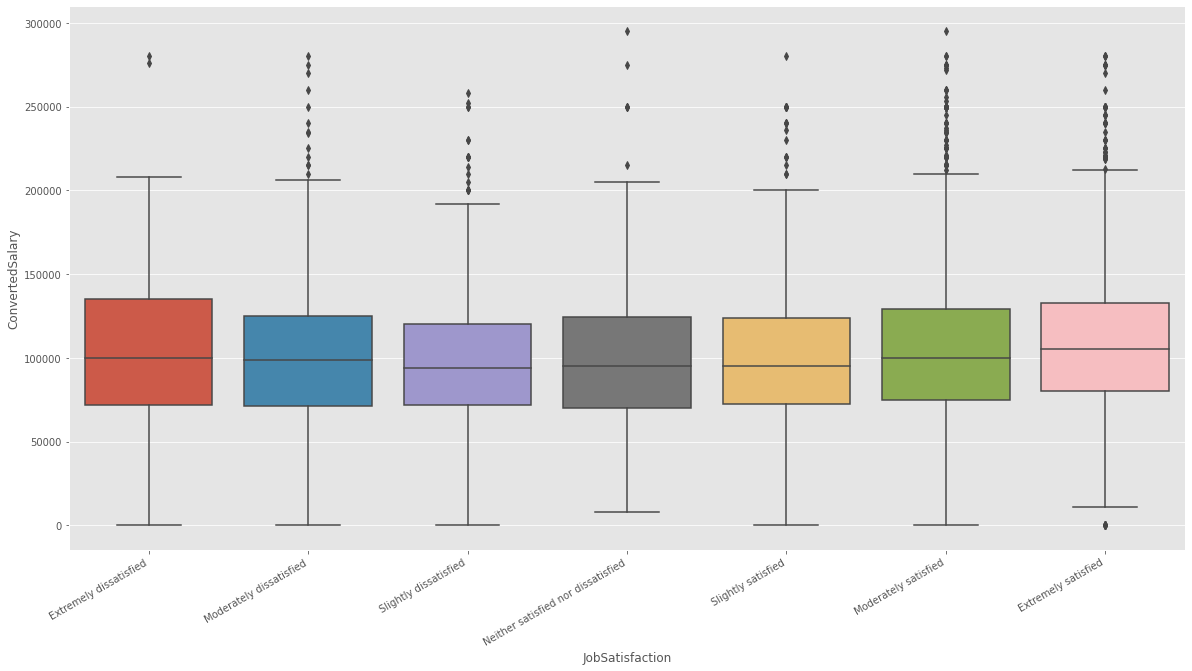

<IPython.core.display.Javascript object>

In [350]:
sns.boxplot(data=sort_by_satisfaction, x="JobSatisfaction", y="ConvertedSalary")
plt.xticks(rotation=30, ha="right")
plt.show()